# Олимпиада по Кибериммунной разработке 

## Создание конструктивно защищённой автономной роботизированной платформы бурения тоннелей 

## Модуль 2

## О документе

Модуль 2 для олимпиады по кибериммунной разработке

Видео разбор:

#### Задача данного модуля

Для заданных начальной точки (20, 20 светло серый квадратик на карте) и конечной точки (691, 68 светло синий квадратик на карте) создать маршрут, содержащий **не менее пяти** промежуточных путевых точек (точка маршрута) и **не более десяти**. Запустите симуляцию и убедитесь, что АРПБТ успешно проходит этот маршрут.

Учитывайте геометрические особенности тоннеля, АРПБТ не должен задеть стены шахты. В этом поможет модуль Датчиков.

На рисунке 1 изображена диаграмма потоков данных с учетом добавления модуля Датчиков, так как используется виртуальная среда, а сами датчики (лидар, ультразвуковые и т.д.) для определения расстояния используют отражение волны, мы будем запрашивать координаты и общую схему шахты, для математического расчёта расстояния.

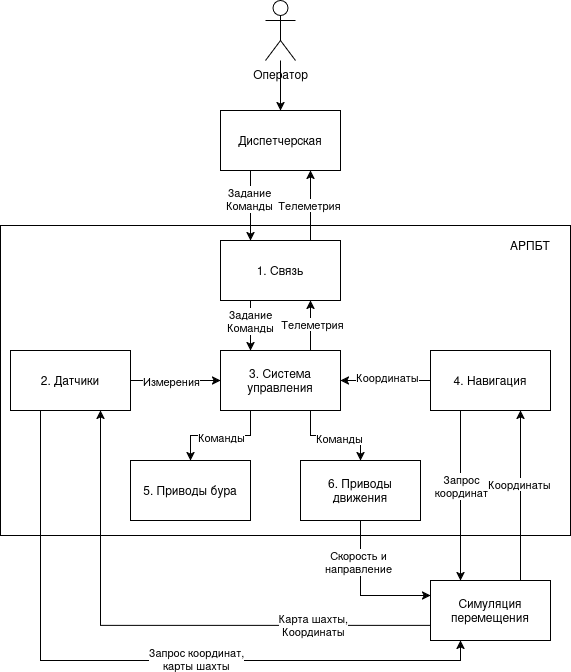

Рисунок 1. Диаграмма потоков данных с модулем Датчиков

**Задачи:**

1. Необходимо дописать взаимодействие между сущностями Sensors и ControlSystem.
2. Необходимо реализовать движение по точкам маршрута, по аналогии с движением по контрольным точкам, только в них бурить тоннель не нужно.
3. ***(Опционально)*** АРПБТ должен как можно быстрее пройти маршрут. (**Вся работы по ускорению АРПБТ происходит в блокноте, в папке src нет необходимости изменений**)

Перенесите реализованный код сущности **ControlSystem** из модуля 1 в данный модуль

Общий пул очереди

In [ ]:
from multiprocessing import Queue

events_queue = Queue()

Классы Event

In [ ]:
from dataclasses import dataclass


# формат управляющих команд
@dataclass
class ControlEvent:
    operation: str


@dataclass
class Event:
    source: str  # отправитель
    destination: str  # получатель
    operation: str  # чего хочет (запрашиваемое действие)
    parameters: str  # с какими параметрами

Создадим общего менеджера очереди

In [ ]:
from multiprocessing import Queue, Process
from multiprocessing.queues import Empty
from time import sleep


# Класс
class QueueManage(Process):

    def __init__(self, events_q: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self._events_q = events_q  # очередь событий входящие сообщения
        self._control_q = (
            Queue()
        )  # очередь управляющих команд (например, для остановки монитора)
        self._entity_queues = {}  # словарь очередей известных монитору сущностей
        self._force_quit = False  # флаг завершения работы монитора

    # регистрация очереди новой сущности
    def add_entity_queue(self, entity_id: str, queue: Queue):
        # print(f"[ИНФО] регистрируем сущность {entity_id}")
        self._entity_queues[entity_id] = queue

    def _proceed(self, event):
        # print(f'[ИНФО] отправляем запрос {event}')
        try:
            # найдём очередь получателя события
            dst_q: Queue = self._entity_queues[event.destination]
            # и положим запрос в эту очередь
            dst_q.put(event)
        except Exception as e:
            # например, запрос пришёл от или для неизвестной сущности
            print(f"[ИНФО] ошибка выполнения запроса {e}")

    # основной код работы монитора безопасности
    def run(self):
        # print('[ИНФО] старт')

        # в цикле проверяет наличие новых событий,
        # выход из цикла по флагу _force_quit
        while self._force_quit is False:
            event = None
            try:
                # ожидание сделано неблокирующим,
                # чтобы можно было завершить работу монитора,
                # не дожидаясь нового сообщения
                event = self._events_q.get_nowait()
                self._proceed(event)
            except Empty:
                # сюда попадаем, если новых сообщений ещё нет,
                # в таком случае немного подождём
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[ИНФО] ошибка обработки {e}, {event}")
            self._check_control_q()
        # print('[ИНФО] завершение работы')

    # запрос на остановку для завершения работы
    # может вызываться вне процесса
    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            #  print(f"[ИНФО] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность ControlSystem

#### Сущность Sensors

Сущность модуля Датчики, реализует опрос расстояний до препятствий в шахте. Использует для этого 6 направлений опроса (360/6 = 60 градусов это один сектор опроса). Позволяет корректировать движения АРПБТ по тоннелю.

In [ ]:
import requests
from src.sensors_calc import calculate_obstacle_distances
from multiprocessing import Queue, Process


class Sensors(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False
        self._config = None

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")

        response = requests.get(
            "http://127.0.0.1:5000/config"
        )  # URL для получения конфигурации карты шахты
        response.raise_for_status()
        self._config = response.json()

        while self._force_quit is False:
            try:
                sleep(0.02)
                response = requests.get(
                    "http://127.0.0.1:5000/position"
                )  # URL для получения текущих координат
                response.raise_for_status()
                coordinates = response.json()

                obstacle_distances = calculate_obstacle_distances(
                    coordinates["x"],
                    coordinates["y"],
                    self._config["obstacles"],
                    (self._config["field_width"], self._config["field_height"]),
                    30,
                )

                # print(f"[{self.__class__.__name__}]Текущие расстояния до препятствия: {obstacle_distances}")

                event = Event(
                    source=self.__class__.__name__,
                    destination="ControlSystem",
                    operation="get_directions",
                    parameters=obstacle_distances,
                )
                self.events_queue.put(event)
                self._check_control_q()
            except requests.exceptions.RequestException as e:
                print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
                self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Communication

In [ ]:
from multiprocessing import Queue, Process


class Communication(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        print(f"[{self.__class__.__name__}] отправляем новое задание")

        # Отметили точки в симуляторе и скопировали её
        task =    
        # запрос для сущности ControlSystem с передачей задания
        event = Event(
            source=self.__class__.__name__,
            destination="ControlSystem",
            operation="new_task",
            parameters=task,
        )

        self.events_queue.put(event)
        print(f"[{self.__class__.__name__}] завершение работы")

#### Сущность Navigation

In [ ]:
import requests
from multiprocessing import Queue, Process


class Navigation(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            try:
                sleep(0.05)
                response = requests.get(
                    "http://127.0.0.1:5000/position"
                )  # URL для получения текущих координат
                response.raise_for_status()
                coordinates = response.json()
                # print(f"[{self.__class__.__name__}]Текущая позиция: X={coordinates['x']}, Y={coordinates['y']}")
                event = Event(
                    source=self.__class__.__name__,
                    destination="ControlSystem",
                    operation="get_coordinates",
                    parameters=coordinates,
                )
                self.events_queue.put(event)
                self._check_control_q()
            except requests.exceptions.RequestException as e:
                print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
                self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Servos

In [ ]:
from multiprocessing import Queue, Process


class Servos(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "set_velocity":
                # print(f"[{self.__class__.__name__}] {event.source} прислал новые параметры управления {event.parameters}")
                try:
                    data = event.parameters
                    response = requests.post(
                        "http://127.0.0.1:5000/set_velocity", json=data
                    )  # URL для обновления параметров скорости и направления движения
                    response.raise_for_status()
                except requests.exceptions.RequestException as e:
                    print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
        except Empty:
            sleep(0.05)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Drill

In [ ]:
from multiprocessing import Queue, Process


class Drill(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")

        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "drilling":
                print(f"[{self.__class__.__name__}] бурим тоннель")
        except Empty:
            sleep(0.1)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

Инициализация модулей

In [ ]:
queue_manager = QueueManage(events_queue)
communication = Communication(events_queue)
control_system = ControlSystem(events_queue)
navigation = Navigation(events_queue)
servos = Servos(events_queue)
sensors = Sensors(events_queue)
drill = Drill(events_queue)

Добавляем в общую очередь все реализованные сущности, можно сказать регистрируем их в менеджере Очереди

In [ ]:
queue_manager.add_entity_queue(
    communication.__class__.__name__, communication.entity_queue()
)
queue_manager.add_entity_queue(
    control_system.__class__.__name__, control_system.entity_queue()
)
queue_manager.add_entity_queue(navigation.__class__.__name__, navigation.entity_queue())
queue_manager.add_entity_queue(servos.__class__.__name__, servos.entity_queue())
queue_manager.add_entity_queue(sensors.__class__.__name__, sensors.entity_queue())
queue_manager.add_entity_queue(drill.__class__.__name__, drill.entity_queue())

Запуск симуляции

In [ ]:
queue_manager.start()
communication.start()
control_system.start()
navigation.start()
sensors.start()
servos.start()
drill.start()
sleep(160)
queue_manager.stop()
communication.join()
control_system.stop()
navigation.stop()
sensors.stop()
servos.stop()
drill.stop()

После успешного прохождения маршрута, модуль 2 будет выполнен. Переходите к 3 модулю

Не забудьте сохранить все изменения и маршрут.  **Ниже вставьте ваш маршрут или оставьте его в Communication**